<a href="https://colab.research.google.com/github/NganTran-0017/LING5412/blob/main/LSTM-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DEEP LEARNING MODELS - PART 1**
Recently, deep learning has been proven to be outperformed in most NLP tasks. LSTM, a special model of RNN, is able to learn long-term dependencies, overcoming the vanishing gradient problem of RNN. Additional, LSTM can learn the sequence bidirectionally (one at a time). CNN was originally produced for image classification, but later on it also achieves a good performance for the text classification. However, a drawback of such deep learning models is that it requires a lot of data to learn. Our dataset is imbalanced in nature. The class 1 (possitive) only has 946 instances (nearly 10% of the dataset), so it may be not sufficient for the deep learning model to be optimized. Data augmentation, and oversampling should be considered to increase the size of this minor class.

We are going to build and train the following models:

*   LSTM-based models: Vanilla biLSTM, Stacked biLSTM, biLSTM with attention layer
*   CNN



In [ ]:
# Loading libraries
import os
import tarfile
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, roc_auc_score
import tensorflow_datasets as tfds
import tensorflow as tf
import torch
import sklearn
tfds.disable_progress_bar()
from keras import backend as K


In [ ]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla K80


# Loading data

In [ ]:
# Uncomment this line if running with a different account
# Unzip the dataset
#!unzip "/content/dontpatronizeme_v1.3.zip" -d "/content/drive/MyDrive/"

In [ ]:
# Opening the file from MyDrive
file = open(r'/content/drive/MyDrive/dontpatronizeme_v1.3/dontpatronizeme_pcl.tsv')
reader = csv.reader(file, delimiter="\t")
data = []
for row in reader:
  data.append(row)


In [ ]:
df = pd.DataFrame(data[5:],  columns = ['docID', 'keyword', 'country', 'paragraph', 'label' ] )
df

,docID,keyword,country,paragraph,label
0,@@4703096,immigrant,jm,NBC and Spanish-language Univision both declin...,0
1,@@25567226,in-need,hk,A second T-Home project is being launched in t...,0
2,@@1824078,poor-families,tz,Camfed would like to see this trend reversed ....,4
3,@@1921089,refugee,tz,Kagunga village was reported to lack necessary...,0
4,@@40039380,women,ng,Haruna stressed the need for specific approach...,0
...,...,...,...,...,...
10053,@@16413808,immigrant,my,"To me , I am always mindful that we are dealin...",4
10054,@@8676630,vulnerable,jm,Other themes included promoting the inclusion ...,0
10055,@@7688552,immigrant,gb,It came as the CDU was also humiliated by the ...,0
10056,@@4916290,hopeless,in,"Those were only days of helplessness , she say...",0


# Data pre-processing

As we participate in Task 1 - binary classification. We need to convert the 5-class lables into binary.

0    9112
1     946
Name: label, dtype: int64


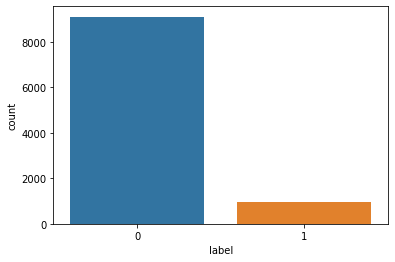

In [ ]:
# Turning labels to binary
df['label'] = df['label'].astype(str)
label_dic = {'0':0,
             '1':0,
             '2':1,
             '3':1,
             '4':1}
df['label'] = df['label'].map(label_dic)
print(df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.show()

# Developing models

### Creating helper functions

In [ ]:
# Defining an evaluation metric function

# Get the measurements of ROC curve for each model
def get_roc_curve (y_true, y_pred):
  # Get arrays of FPR and recall using roc_curve
  FPR, recall, threshold = sklearn.metrics.roc_curve(y_true, y_pred)
  # Get testing accuracy:
  acc = sklearn.metrics.accuracy_score( y_test,y_pred)
  # Get testing macro-f1:
  f1 = sklearn.metrics.f1_score(y_test, y_pred,  average = 'macro', zero_division=1)
  # Get auc score
  auc = sklearn.metrics.auc(FPR, recall)
  roc = {'fpr': FPR, 'tpr': recall, 'auc': auc, 'accuracy': acc, 'macro-F1': f1}
  return roc

# Defining a function to print out performance of models in classification metric 
def printing_eval_scores (y_true, y_pred, report=''):
  accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
  precision = sklearn.metrics.precision_score(y_true, y_pred, average='macro', zero_division = 1)
  recall = sklearn.metrics.recall_score(y_true, y_pred, average='macro', zero_division = 1)
  f1 = sklearn.metrics.f1_score(y_true, y_pred , average='macro', zero_division = 1)
  cmatrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
  print('accuracy score: {:.3f}'.format(accuracy))
  print('precision score: {:.3f}'.format(precision))
  print('recall score: {:.3f}'.format(recall))
  print('F1 score: {:.3f}'.format(f1))
  if report is True:
    print(classification_report(y_true, y_pred))
  else:
    pass
  return accuracy, precision, recall, f1

# Creating an empty dictionary to save ROC scores of all models
roc = {}

### Spliting data

In [ ]:
# Splitting the data into training (80%) and test sets(20%), 
# then spliting the training set into training and validation subsets with the same rate
X = df['paragraph']
y = df['label']
X_train_large, X_test, y_train_large, y_test = train_test_split (X, y, train_size = 0.8, random_state = 42, shuffle = True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split (X_train_large, y_train_large, train_size = 0.8, random_state = 42, shuffle = True, stratify=y_train_large)

print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_val, y_val: ', X_test.shape, y_test.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)
print(y_train.value_counts())

Shapes of X_train, y_train:  (6436,) (6436,)
Shapes of X_val, y_val:  (2012,) (2012,)
Shapes of X_test, y_test:  (2012,) (2012,)
0    5830
1     606
Name: label, dtype: int64


### Oversampling
To handle class imbalance issue, we oversample the minor class so that both classes have  equal numbers of examples. We generate new instances for the class 1 by randomly duplicating instances from training set of this class. Note that we only oversample for the train set, so that it will not affect reliability of the models. 

In [ ]:
# Getting instances of each class 
bool1_train_labels = y_train != 0
X_train_1 = X_train[bool1_train_labels]
X_train_0 = X_train[~bool1_train_labels]
y_train_1 = y_train[bool1_train_labels]
y_train_0 = y_train[~bool1_train_labels]

print('shape of X_train - Class 1: {}, Class 0: {}'.format(X_train_1.shape, X_train_0.shape))
print('shape of y_train - Class 1: {}, Class 0: {}'.format(y_train_1.shape, y_train_0.shape))


# Oversampling the class 1 on train set
ids = np.arange(len(X_train_1.to_list())) # getting index of instance in class 1 in train set
choices = np.random.choice(ids, size = len(X_train_0.to_list())) # randomly duplicate index of instances in class 1 until it gets a size of the class 0

res_X_train_1 = np.array(X_train_1.to_list())[choices] # having the resampled train set of class 1
res_y_train_1 = np.array(y_train_1)[choices]

print('\nWith oversampling: \nshape of X_train - Class 1: {}, Class 0: {}'.format(res_X_train_1.shape, X_train_0.shape))
print('shape of y_train - Class 1: {}, Class 0: {}'.format(res_y_train_1.shape, y_train_0.shape))

# Concatenate oversalmpled class 1, and class 0 into train set
res_X_train = np.concatenate([res_X_train_1, X_train_0], axis=0)
res_y_train = np.concatenate([res_y_train_1, y_train_0], axis=0)

# Shuffle after concatenate the two-class data.
order = np.arange(len(res_y_train))
np.random.shuffle(order)
res_X_train = res_X_train[order]
res_y_train = res_y_train[order]

print('\nWith oversampling and shuffling: \nshape of resampled_X_train: {}, resampled_y_train: {}'.format(res_X_train.shape, res_y_train.shape))


shape of X_train - Class 1: (606,), Class 0: (5830,)
shape of y_train - Class 1: (606,), Class 0: (5830,)

With oversampling: 
shape of X_train - Class 1: (5830,), Class 0: (5830,)
shape of y_train - Class 1: (5830,), Class 0: (5830,)

With oversampling and shuffling: 
shape of resampled_X_train: (11660,), resampled_y_train: (11660,)


### Text representation

**Text vectorization**

In [ ]:
# Uncomment these codes for running with other Google account
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip -d "/content/drive/MyDrive/"

In [ ]:
# Create vectorizer 
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=225) # Tokennize documents

text_ds = tf.data.Dataset.from_tensor_slices(X_train.to_list()+X_val.to_list()).batch(32) 
vectorizer.adapt(text_ds)

# Create vocabulary 
voc = vectorizer.get_vocabulary()
print(vectorizer.get_vocabulary()[:5])
word_index = dict(zip(voc, range(len(voc))))

['', '[UNK]', 'the', 'to', 'of']


In [ ]:
# Vectorize documents of the train, validation, and test set
X_train_vec = vectorizer(np.array(res_X_train)).numpy()
X_val_vec = vectorizer(np.array([[s] for s in X_val.to_list()])).numpy()
X_test_vec = vectorizer(np.array([[s] for s in X_test.to_list()])).numpy()

y_train = res_y_train 
y_val = np.array(y_val)
y_test = np.array(y_test)

**Loading GloVe pretrained embedding model**

In [ ]:
embeddings_index = {}
EMBEDDING_DIM = 300
hits = 0
misses = 0

# Loading embeddings from GloVe
f = open(os.path.join('/content/drive/MyDrive', 'glove.6B.300d.txt')) # Download the GloVe embeddings
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

# Getting embedding matrix 
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 17967 words (2033 misses)


In [ ]:
embedding_matrix.shape

(20001, 300)

## **LSTM-based models**

In [ ]:
# Set up parameters
n_epochs = 15
n_units = 64
optimizer = 'rmsprop'
MAX_SEQUENCE_LENGTH = 225

### Vanilla biLSTM

In [ ]:
############################ Creating the model #######################
input_dim = len(word_index) + 1

## Embedding layer
embedding_layer = tf.keras.layers.Embedding(input_dim = input_dim, # turn into dense vector representation
                                            output_dim = EMBEDDING_DIM, 
                                            weights=[embedding_matrix],   # Using embeddings from GloVe embeddings
                                            trainable=True,
                                            mask_zero = True) 
sequence_input = tf.keras.Input(shape=(X_train_vec.shape[1],), dtype=tf.int64)
embedded_sequences = embedding_layer(sequence_input)

## Hidden layers
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_units,  return_sequences = False,  trainable=True)) (embedded_sequences) # take inputs of embeddings, and all output hidden states with return_sequences = True
x = tf.keras.layers.Dense(32, activation = 'relu') (x)
x = tf.keras.layers.Dropout(0.2) (x)

## output layer
output = tf.keras.layers.Dense(1, activation = 'sigmoid') (x)

## combine all in one model
model = tf.keras.Model(sequence_input,output)
print(model.summary())

### Compile the model for training
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
              optimizer = optimizer, 
              metrics = ['accuracy'])

##################################### Training the model  #######################################

history = model.fit(X_train_vec, y_train, validation_data=(X_val_vec, y_val),
          epochs=n_epochs, batch_size=32)


################################### testing the model #################################
pred_label = (model.predict(X_test_vec) > 0.5).astype("int32")
true_label = y_test 

test_loss, test_acc = model.evaluate (X_test_vec,y_test)
print('Test acurracy: ', test_acc)
print('\nTesting performance:\n Loss: {:.3f} - Accuracy: {:.3f}'. format(test_loss, test_acc))

printing_eval_scores (true_label, pred_label, report=True)

roc['vanila-biLSTM'] = get_roc_curve(true_label, pred_label)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 225)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 225, 300)          6000300   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               85248     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                           

The model achieved about **0.56 on macro F1 score**, lower than some classic models. While class 0 has 0.95 on F1 score, the performance on class 1 is very low, 0.17. This means that the model suffers a lot class imbalance issue, and our oversampling seems not really help.

### Stacked biLSTM
In this model, we stack together two biLSTM models. All hidden states of the previous biLSTM layer is input into the following biLSTM layer. 

In [ ]:
############################ Creating the model #############################
input_dim = len(word_index) + 1

## Embedding layer
embedding_layer = tf.keras.layers.Embedding(input_dim = input_dim, # turn into dense vector representation
                                            output_dim = EMBEDDING_DIM, 
                                            weights=[embedding_matrix],   # Using embeddings from GloVe embeddings
                                            trainable=True,
                                            mask_zero = True)
sequence_input = tf.keras.Input(shape=(X_train_vec.shape[1],), dtype=tf.int64)
embedded_sequences = embedding_layer(sequence_input)

## Hidden state layers
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_units,  return_sequences = True,  trainable=True)) (embedded_sequences) # take inputs of embeddings, and all output hidden states with return_sequences = True
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_units,  return_sequences = False,  trainable=True)) (x) 
x = tf.keras.layers.Dense(32, activation = 'relu') (x)
x = tf.keras.layers.Dropout(0.2) (x)

## output layer
output = tf.keras.layers.Dense(1, activation = 'sigmoid') (x)

## combine all in one model
model = tf.keras.Model(sequence_input,output)
print(model.summary())

## Compile the model for training
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
              optimizer = optimizer, 
              metrics = ['accuracy'])

####################################   Training the model   ########################################

history = model.fit(X_train_vec, y_train, validation_data=(X_val_vec, y_val),
          epochs=n_epochs, batch_size=32)


################################### Testing the model   ########################################
pred_label = (model.predict(X_test_vec) > 0.5).astype("int32")
true_label = y_test 

test_loss, test_acc = model.evaluate (X_test_vec,y_test)
print('Test acurracy: ', test_acc)
print('\nTesting performance:\n Loss: {:.3f} - Accuracy: {:.3f}'. format(test_loss, test_acc))

printing_eval_scores (true_label, pred_label, report=True)

roc['stacked-biLSTM'] = get_roc_curve(true_label, pred_label)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 225)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 225, 300)          6000300   
                                                                 
 bidirectional_2 (Bidirectio  (None, 225, 64)          85248     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0   

The model performed slightly better than the vanila biLSTM, **0.57 on macro F1 score**. Similarly, the performance on class 1 is very low, 0.18, and the model suffers from the class imbalance issue.

### **BiLSTM with attention**
In this model, we also based on biLSTM model. However, inspired by Zhou et al. (2016) [link paper](https://https://aclanthology.org/P16-2034.pdf) to add an attention layer on top of biLSTM layer.
Specifically, we applied tanh activation function for all hidden states that the biLSTM produced. Then, we applied softmax for those transposed weights given by the previous layer. Finally, we computed element-wise mutiplication of hidden states with the attention weight as updated sentence representations. This attention layer is created by using the equations (9), (10), and (11) in the paper. 


In [ ]:
########################### Creating the model ###############################
input_dim = len(word_index) + 1

## Embedding layer
embedding_layer = tf.keras.layers.Embedding(input_dim = input_dim,
                                            output_dim = EMBEDDING_DIM, 
                                            weights=[embedding_matrix],  #embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), 
                                            trainable=True,
                                            mask_zero = True) # turn into dense vector representation
sequence_input = tf.keras.Input(shape=(X_train_vec.shape[1],), dtype=tf.int64)
embedded_sequences = embedding_layer(sequence_input)

lstm_hs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_units,  return_sequences = True,  trainable=True)) (embedded_sequences) # take inputs of embeddings, and all output hidden states with return_sequences = True

# Attention layers
attention = tf.keras.layers.Dense(1, activation = 'tanh') (lstm_hs) #apply tanh activation function for all hidden states LSTM produced
attention = tf.keras.layers.Flatten()(attention) # transform tensor of attention weights in a vector 
attention = tf.keras.layers.Activation('softmax') (attention) # applying softmax activation function of the hidden states output to get attention weights between 0 and 1, and sum to 1
attention = tf.keras.layers.RepeatVector (n_units*2) (attention) # repeat attention weights to have same dimensions with hidden states (= unit*2 as it's biLSTM) for compute element-wise multiplying
attention = tf.keras.layers.Permute ([2,1]) (attention) # permute the dimension of the attention weight for being able to multiply with hidden states

attention_weight = tf.keras.layers.Multiply()([lstm_hs, attention]) # computing element-wise mutiplying hidden states with the attention weight as updated sentence representations
attention_weight = tf.keras.layers.Lambda(lambda x: K.sum(x, axis = 1)) (attention_weight) # summing up all weights in the updated sentence representation for unputing into a fully-connected layer at the end 

## Output layer
dropout = tf.keras.layers.Dropout(0.2) (attention_weight)
output = tf.keras.layers.Dense(1, activation = 'sigmoid') (dropout)

## Combine all in one model
model = tf.keras.Model(sequence_input,output)
print(model.summary())

## Compile the model for training
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
              optimizer = optimizer, #tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics = ['accuracy'])

############################### Training the model  #######################################

history = model.fit(X_train_vec, y_train, validation_data=(X_val_vec, y_val),
          epochs=n_epochs, batch_size=32)


############################## Testing the model  ######################################
pred_label = (model.predict(X_test_vec) > 0.5).astype("int32")
true_label = y_test 

test_loss, test_acc = model.evaluate (X_test_vec,y_test)
print('Test acurracy: ', test_acc)
print('\nTesting performance:\n Loss: {:.3f} - Accuracy: {:.3f}'. format(test_loss, test_acc))

printing_eval_scores (true_label, pred_label, report=True)

roc['att-biLSTM'] = get_roc_curve(true_label, pred_label)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 225)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 225, 300)     6000300     ['input_6[0][0]']                
                                                                                                  
 bidirectional_5 (Bidirectional  (None, 225, 128)    186880      ['embedding_5[0][0]']            
 )                                                                                                
                                                                                                  
 dense_10 (Dense)               (None, 225, 1)       129         ['bidirectional_5[0][0]']  

The model yielded a much higher peformance, **0.62 on macro F1 score**, compared to previous biLSTM model, meaning that the attention layer we created was effective. By assigning higher weights to important features, the model converged more easily. However, performance in the class 1 (minor class) is still low, 0.30 on F1 score. In the future, we would like to implement more effective technique to handle this imbalance issue.

## CNN

In [ ]:
n_epochs = 20
n_units = 64
optimizer = 'adam'
MAX_SEQUENCE_LENGTH = 225

############################ Creating the model #############################
input_dim = len(word_index) + 1

## Embedding layer
embedding_layer = tf.keras.layers.Embedding(input_dim = input_dim,
                                            output_dim = EMBEDDING_DIM, 
                                            weights=[embedding_matrix],  # using weight of pretrained embeddings 
                                            trainable=True,
                                            mask_zero = True) # turn into dense vector representation
sequence_input = tf.keras.Input(shape=(X_train_vec.shape[1],), dtype=tf.int64)
embedded_sequences = embedding_layer(sequence_input)

# CNN layers
x = tf.keras.layers.Conv1D(n_units, 5 , activation='relu') (embedded_sequences)
x = tf.keras.layers.MaxPooling1D() (x)
x = tf.keras.layers.Flatten() (x)
x = tf.keras.layers.Dense(32, activation='relu') (x) 
x = tf.keras.layers.Dropout(0.2) (x)

## output layer
output = tf.keras.layers.Dense(1, activation = 'sigmoid') (x)

## combine in one
model = tf.keras.Model(sequence_input,output)
print(model.summary())

## Compile the model for training
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
              optimizer = optimizer,
              metrics = ['accuracy'])

############################### Training the model   ##################################

history = model.fit(X_train_vec, y_train, validation_data=(X_val_vec, y_val),
          epochs=n_epochs, batch_size=32)


############################### testing the model    ################################
pred_label = (model.predict(X_test_vec) > 0.5).astype("int32")
true_label = y_test 

test_loss, test_acc = model.evaluate (X_test_vec,y_test)
print('Test acurracy: ', test_acc)
print('\nTesting performance:\n Loss: {:.3f} - Accuracy: {:.3f}'. format(test_loss, test_acc))

printing_eval_scores (true_label, pred_label, report=True)

roc['CNN'] = get_roc_curve(true_label, pred_label)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 225)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 225, 300)          6000300   
                                                                 
 conv1d (Conv1D)             (None, 221, 64)           96064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 110, 64)          0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 7040)              0         
                                                                 
 dense_8 (Dense)             (None, 32)                225312    
                                                           

We can see that CNN model did not perform better than any of biLSTM with a **macro F1 score of about 0.55**. Also, the model also failed to predict class 1 (minor class).

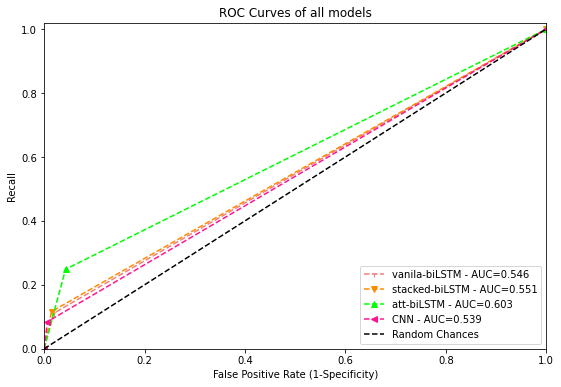

In [ ]:
def graph_multi_ROC (rocs):
  # Set color for each model
  colors = {'vanila-biLSTM': 'lightcoral','stacked-biLSTM': 'darkorange', 'att-biLSTM':'lime', 'CNN': 'deeppink'} #, 'NB': 'steelblue',  'XGB': 'purple','DT': 'magenta','RF': 'deeppink','KNN': 'darkturquoise','BERT': 'darkred', 'GPT': 'blue'
  # Set marker for each model          
  markers = {'vanila-biLSTM':'1--','stacked-biLSTM': 'v--', 'att-biLSTM': '^--', 'CNN':'<--'} #, 'XGB': '*--', 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'NB': 'x--', 'BERT':'<--', 'GPT': '>--'}
  
  plt.figure(figsize=(9,6))
  for model in rocs:
    plt.plot( rocs[model]['fpr'], rocs[model]['tpr'], markers[model], color=colors[model], label= model+' - AUC=' + str(rocs[model]['auc'].round(3)) )
  
  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'ROC Curves of all models')
  plt.show()

graph_multi_ROC(roc)

The model performances are visualized through an overlaid ROC curves above. In this plot, the higher recall and the lower FPR that the model can achieve, the better that model is. A model that randomly classify data is represented as a straight dotted line in black. Consistently, the BiLSTM with attention model has the best AUC score.

In [ ]:
# Export performance to a txt file
txtfile = open('LSTM-CNN_rocs2.txt','w')
for i in roc.keys():
  txtfile.write(str(i) + '=' + str(roc[i])+'\n')
  print(roc[i])
txtfile.close()

{'fpr': array([0.        , 0.01919912, 1.        ]), 'tpr': array([0.        , 0.11111111, 1.        ]), 'auc': 0.5459559943926373, 'accuracy': 0.8991053677932406, 'macro-F1': 0.5588553283181492}
{'fpr': array([0.        , 0.01481075, 1.        ]), 'tpr': array([0.        , 0.11640212, 1.        ]), 'auc': 0.5507956824468069, 'accuracy': 0.9035785288270378, 'macro-F1': 0.5668162669188119}
{'fpr': array([0.        , 0.04278662, 1.        ]), 'tpr': array([0.        , 0.24867725, 1.        ]), 'auc': 0.6029453166041208, 'accuracy': 0.8906560636182903, 'macro-F1': 0.6200319329750889}
{'fpr': array([0.        , 0.00658256, 1.        ]), 'tpr': array([0.        , 0.08465608, 1.        ]), 'auc': 0.5390367642150418, 'accuracy': 0.908051689860835, 'macro-F1': 0.5494353719016267}
